# descriptive stats on data

- it became clear from the feature engineering and trying to run a simple linear model that the size of the data is cumbersome

- moved from ml.m52xlarget to ml.m5.4xlarge

- the number of observations in the test data is 15 days
- in the training it was 1687 days


- we have established that the items have to be pooled in some way to account for the sparsity of observations for some items
    * at least for all stores and likely by item grouping
   
- model is regression based models , gradient boosted decision trees according to learnings from kaggle forecasting competitions (Bojer and Meldgaard)

- neural networks
    
    

# stratification for modelling
- start with the simplest which is regression by item pooled across store
- indicator for has the item been sold in this store previously


- given time constraints am going to run lstm neural network model 
- with multioutput 
-

reference: 
- https://machinelearningmastery.com/multi-output-regression-models-with-python/ 
- https://machinelearningmastery.com/deep-learning-models-for-multi-output-regression/
- https://www.tensorflow.org/tutorials/structured_data/time_series
Chollet

In [ ]:
!pip install keras
!pip install tensorflow

In [243]:
import pandas as pd
import numpy as np

In [244]:
%%time
#df_train = pd.read_feather("data/trainpy.feather")
data = pd.read_csv("data.csv")
holiday_events = pd.read_csv("data/holidays_events.csv")

CPU times: user 9.63 ms, sys: 4.16 ms, total: 13.8 ms
Wall time: 13.5 ms


In [245]:
hols = holiday_events[(holiday_events['locale_name'] == "Ecuador") & (~holiday_events['transferred'])]
hols.set_index('date', inplace=True)
hols.index = pd.to_datetime(hols.index)

hols['type'].value_counts()

workday = hols[hols['type'] == 'Work Day']
hols = hols[hols['type'] != 'Work Day']

print(hols.head())
workday.head()

workday.shape

data.head()

dt = data.pivot(values='unit_sales', index=['date'], columns='store_nbr')
dt = dt.fillna(0)
dt.index = pd.to_datetime(dt.index)

dt.shape

dt.columns = ["s" + str(s) for s in dt.columns.values.tolist()]
dt.head()

                  type    locale locale_name  \
date                                           
2012-08-10     Holiday  National     Ecuador   
2012-10-12    Transfer  National     Ecuador   
2012-11-02     Holiday  National     Ecuador   
2012-11-03     Holiday  National     Ecuador   
2012-12-21  Additional  National     Ecuador   

                                    description  transferred  
date                                                          
2012-08-10        Primer Grito de Independencia        False  
2012-10-12  Traslado Independencia de Guayaquil        False  
2012-11-02                      Dia de Difuntos        False  
2012-11-03              Independencia de Cuenca        False  
2012-12-21                            Navidad-4        False  


s1   s2   s3   s4   s5   s6   s7   s8   s9  s10  ...  s45  s46  \
date                                                          ...             
2016-01-12  0.0  0.0  0.0  0.0  0.0  0.0  4.0  0.0  0.0  0.0  ...  0.0  0.0   
2016-01-14  0.0  0.0  0.0  0.0  0.0  0.0  6.0  0.0  0.0  0.0  ...  0.0  0.0   
2016-01-15  0.0  0.0  0.0  0.0  0.0  0.0  2.0  0.0  0.0  0.0  ...  0.0  0.0   
2016-01-16  0.0  0.0  0.0  0.0  0.0  0.0  5.0  0.0  0.0  0.0  ...  0.0  0.0   
2016-01-17  0.0  0.0  7.0  0.0  4.0  0.0  2.0  0.0  0.0  0.0  ...  0.0  0.0   

            s47  s48  s49  s50  s51  s52  s53  s54  
date                                                
2016-01-12  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2016-01-14  5.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2016-01-15  2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2016-01-16  4.0  6.0  0.0  0.0  0.0  0.0  0.0  0.0  
2016-01-17  6.0  9.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 54 columns]

In [246]:
d = pd.DataFrame(list(dt.index), columns=['date'])
d['workday'] = d['date'].apply(lambda x: 1 if x in workday.index else 0)
print("n workdays:", d['workday'].sum())
d['hols'] = d['date'].apply(lambda x: 1 if x in hols.index else 0)
print("n workdays:", d['hols'].sum())
d.set_index('date', inplace=True)
d.index = pd.to_datetime(d.index)
d

df = pd.merge(d, dt, how='left', on='date')
print(df.columns.tolist())
df.head()
type(df.index)

n workdays: 1
n workdays: 57
['workday', 'hols', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27', 's28', 's29', 's30', 's31', 's32', 's33', 's34', 's35', 's36', 's37', 's38', 's39', 's40', 's41', 's42', 's43', 's44', 's45', 's46', 's47', 's48', 's49', 's50', 's51', 's52', 's53', 's54']


pandas.core.indexes.datetimes.DatetimeIndex

In [247]:
dt.index = pd.to_datetime(dt.index)
wdf = pd.get_dummies(dt.index.weekday, prefix='w', drop_first=True)
wdf.index = dt.index
mdf = pd.get_dummies(dt.index.month, prefix='m', drop_first=True)
mdf.index =  dt.index

ddf = pd.concat([wdf, mdf], axis=1)
ddf


w_1  w_2  w_3  w_4  w_5  w_6  m_2  m_3  m_4  m_5  m_6  m_7  m_8  \
date                                                                          
2016-01-12    1    0    0    0    0    0    0    0    0    0    0    0    0   
2016-01-14    0    0    1    0    0    0    0    0    0    0    0    0    0   
2016-01-15    0    0    0    1    0    0    0    0    0    0    0    0    0   
2016-01-16    0    0    0    0    1    0    0    0    0    0    0    0    0   
2016-01-17    0    0    0    0    0    1    0    0    0    0    0    0    0   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2017-08-27    0    0    0    0    0    1    0    0    0    0    0    0    1   
2017-08-28    0    0    0    0    0    0    0    0    0    0    0    0    1   
2017-08-29    1    0    0    0    0    0    0    0    0    0    0    0    1   
2017-08-30    0    1    0    0    0    0    0    0    0    0    0    0    1   
2017-08-31    0    0    1    0    0    0    0    0    0    0    0    0    1   

            m_9  m_10  m_11  m_12  
date                               
2016-01-12    0     0     0     0  
2016-01-14    0     0     0     0  
2016-01-15    0     0     0     0  
2016-01-16    0     0     0     0  
2016-01-17    0     0     0     0  
...         ...   ...   ...   ...  
2017-08-27    0     0     0     0  
2017-08-28    0     0     0     0  
2017-08-29    0     0     0     0  
2017-08-30    0     0     0     0  
2017-08-31    0     0     0     0  

[595 rows x 17 columns]

In [248]:
def shift_series_in_df(df, series_names=[], days_delta=1):
   ret = pd.DataFrame(index=df.index.copy())   
   for sn in series_names:
        ret[f'{sn}_p_{np.abs(days_delta)}'] = df[sn].transform(lambda x: x.shift(days_delta))
   return ret

   
def stack_shifted_sales(df, days_deltas=[1]):
    series_names = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 
                  's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 
                  's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27', 's28', 's29', 
                  's30', 's31', 's32', 's33', 's34', 's35', 's36', 's37', 's38', 's39', 
                  's40', 's41', 's42', 's43', 's44', 's45', 's46', 's47', 's48', 's49', 
                  's50', 's51', 's52', 's53', 's54']

    dfs = [df.copy()]
    for delta in days_deltas:
        shifted = shift_series_in_df(df, series_names=series_names, days_delta=delta)
        dfs.append(shifted)
    return pd.concat(dfs, axis=1, sort=False, copy=False)        
    

In [249]:
series_names = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 
                  's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 
                  's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27', 's28', 's29', 
                  's30', 's31', 's32', 's33', 's34', 's35', 's36', 's37', 's38', 's39', 
                  's40', 's41', 's42', 's43', 's44', 's45', 's46', 's47', 's48', 's49', 
                  's50', 's51', 's52', 's53', 's54']

In [250]:
scaler = MinMaxScaler(feature_range=(0,1))

scaled_cols = scaler.fit_transform(dt[series_names])
dt[series_names] = scaled_cols

In [251]:
dtsh = stack_shifted_sales(dt, days_deltas=[1])
print(dtsh.shape)
# drop first row, no prev vals
#dtsh.dropna(inplace=True)
print(dtsh.shape)
dtsh

(595, 108)
(595, 108)


s1   s2     s3   s4        s5   s6        s7   s8   s9  s10  ...  \
date                                                                      ...   
2016-01-12  0.0  0.0  0.000  0.0  0.000000  0.0  0.153846  0.0  0.0  0.0  ...   
2016-01-14  0.0  0.0  0.000  0.0  0.000000  0.0  0.230769  0.0  0.0  0.0  ...   
2016-01-15  0.0  0.0  0.000  0.0  0.000000  0.0  0.076923  0.0  0.0  0.0  ...   
2016-01-16  0.0  0.0  0.000  0.0  0.000000  0.0  0.192308  0.0  0.0  0.0  ...   
2016-01-17  0.0  0.0  0.175  0.0  0.444444  0.0  0.076923  0.0  0.0  0.0  ...   
...         ...  ...    ...  ...       ...  ...       ...  ...  ...  ...  ...   
2017-08-27  0.0  0.0  0.000  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0  ...   
2017-08-28  0.0  0.0  0.000  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0  ...   
2017-08-29  0.0  0.0  0.000  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0  ...   
2017-08-30  0.0  0.0  0.000  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0  ...   
2017-08-31  0.0  0.0  0.000  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0  ...   

            s45_p_1  s46_p_1   s47_p_1   s48_p_1  s49_p_1  s50_p_1  s51_p_1  \
date                                                                          
2016-01-12      NaN      NaN       NaN       NaN      NaN      NaN      NaN   
2016-01-14      0.0      0.0  0.000000  0.000000      0.0      0.0      0.0   
2016-01-15      0.0      0.0  0.098039  0.000000      0.0      0.0      0.0   
2016-01-16      0.0      0.0  0.039216  0.000000      0.0      0.0      0.0   
2016-01-17      0.0      0.0  0.078431  0.166667      0.0      0.0      0.0   
...             ...      ...       ...       ...      ...      ...      ...   
2017-08-27      0.0      0.0  0.000000  0.000000      0.0      0.0      0.0   
2017-08-28      0.0      0.0  0.000000  0.000000      0.0      0.0      0.0   
2017-08-29      0.0      0.0  0.000000  0.000000      0.0      0.0      0.0   
2017-08-30      0.0      0.0  0.000000  0.000000      0.0      0.0      0.0   
2017-08-31      0.0      0.0  0.000000  0.000000      0.0      0.0      0.0   

            s52_p_1  s53_p_1  s54_p_1  
date                                   
2016-01-12      NaN      NaN      NaN  
2016-01-14      0.0      0.0      0.0  
2016-01-15      0.0      0.0      0.0  
2016-01-16      0.0      0.0      0.0  
2016-01-17      0.0      0.0      0.0  
...             ...      ...      ...  
2017-08-27      0.0      0.0      0.0  
2017-08-28      0.0      0.0      0.0  
2017-08-29      0.0      0.0      0.0  
2017-08-30      0.0      0.0      0.0  
2017-08-31      0.0      0.0      0.0  

[595 rows x 108 columns]

In [252]:
dtsh.columns.shape

(108,)

In [253]:
df0 = pd.concat([d, ddf, dtsh], axis=1)
print(df0.columns)
print(df0.shape)
#print(ddf1.shape)
#print(d.index.dtype)
#print(ddf.index.dtype)
#print(dt.index.dtype)
df0.columns.tolist()
df0.columns

Index(['workday', 'hols', 'w_1', 'w_2', 'w_3', 'w_4', 'w_5', 'w_6', 'm_2',
       'm_3',
       ...
       's45_p_1', 's46_p_1', 's47_p_1', 's48_p_1', 's49_p_1', 's50_p_1',
       's51_p_1', 's52_p_1', 's53_p_1', 's54_p_1'],
      dtype='object', length=127)
(595, 127)


Index(['workday', 'hols', 'w_1', 'w_2', 'w_3', 'w_4', 'w_5', 'w_6', 'm_2',
       'm_3',
       ...
       's45_p_1', 's46_p_1', 's47_p_1', 's48_p_1', 's49_p_1', 's50_p_1',
       's51_p_1', 's52_p_1', 's53_p_1', 's54_p_1'],
      dtype='object', length=127)

In [254]:
df0.dropna(inplace=True)
df0

workday  hols  w_1  w_2  w_3  w_4  w_5  w_6  m_2  m_3  ...  \
date                                                               ...   
2016-01-14        0     0    0    0    1    0    0    0    0    0  ...   
2016-01-15        0     0    0    0    0    1    0    0    0    0  ...   
2016-01-16        0     0    0    0    0    0    1    0    0    0  ...   
2016-01-17        0     0    0    0    0    0    0    1    0    0  ...   
2016-01-18        0     0    0    0    0    0    0    0    0    0  ...   
...             ...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2017-08-27        0     0    0    0    0    0    0    1    0    0  ...   
2017-08-28        0     0    0    0    0    0    0    0    0    0  ...   
2017-08-29        0     0    1    0    0    0    0    0    0    0  ...   
2017-08-30        0     0    0    1    0    0    0    0    0    0  ...   
2017-08-31        0     0    0    0    1    0    0    0    0    0  ...   

            s45_p_1  s46_p_1   s47_p_1   s48_p_1  s49_p_1  s50_p_1  s51_p_1  \
date                                                                          
2016-01-14      0.0      0.0  0.000000  0.000000      0.0      0.0      0.0   
2016-01-15      0.0      0.0  0.098039  0.000000      0.0      0.0      0.0   
2016-01-16      0.0      0.0  0.039216  0.000000      0.0      0.0      0.0   
2016-01-17      0.0      0.0  0.078431  0.166667      0.0      0.0      0.0   
2016-01-18      0.0      0.0  0.117647  0.250000      0.0      0.0      0.0   
...             ...      ...       ...       ...      ...      ...      ...   
2017-08-27      0.0      0.0  0.000000  0.000000      0.0      0.0      0.0   
2017-08-28      0.0      0.0  0.000000  0.000000      0.0      0.0      0.0   
2017-08-29      0.0      0.0  0.000000  0.000000      0.0      0.0      0.0   
2017-08-30      0.0      0.0  0.000000  0.000000      0.0      0.0      0.0   
2017-08-31      0.0      0.0  0.000000  0.000000      0.0      0.0      0.0   

            s52_p_1  s53_p_1  s54_p_1  
date                                   
2016-01-14      0.0      0.0      0.0  
2016-01-15      0.0      0.0      0.0  
2016-01-16      0.0      0.0      0.0  
2016-01-17      0.0      0.0      0.0  
2016-01-18      0.0      0.0      0.0  
...             ...      ...      ...  
2017-08-27      0.0      0.0      0.0  
2017-08-28      0.0      0.0      0.0  
2017-08-29      0.0      0.0      0.0  
2017-08-30      0.0      0.0      0.0  
2017-08-31      0.0      0.0      0.0  

[594 rows x 127 columns]

In [255]:
df0.index

DatetimeIndex(['2016-01-14', '2016-01-15', '2016-01-16', '2016-01-17',
               '2016-01-18', '2016-01-19', '2016-01-20', '2016-01-21',
               '2016-01-22', '2016-01-23',
               ...
               '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25',
               '2017-08-26', '2017-08-27', '2017-08-28', '2017-08-29',
               '2017-08-30', '2017-08-31'],
              dtype='datetime64[ns]', name='date', length=594, freq=None)

In [256]:
from datetime import datetime
cutoff = datetime.strptime('2017-08-16', "%Y-%m-%d")
df_test = df0.loc[df0.index >= cutoff, :]
df_train = df0.loc[df0.index < cutoff, :]

In [345]:
X_cols_stacked = [col for col in df_train.columns if 'p_' in col]
X_cols_caldata = [col for col in df_train.columns if 'w_' in col or 'm_' in col or 'workday' in col or 'hols' in col]
X_cols = X_cols_stacked + X_cols_caldata

X = df_train[X_cols]
X

s1_p_1  s2_p_1  s3_p_1  s4_p_1    s5_p_1    s6_p_1    s7_p_1  \
date                                                                         
2016-01-14  0.000000    0.00   0.000     0.0  0.000000  0.000000  0.153846   
2016-01-15  0.000000    0.00   0.000     0.0  0.000000  0.000000  0.230769   
2016-01-16  0.000000    0.00   0.000     0.0  0.000000  0.000000  0.076923   
2016-01-17  0.000000    0.00   0.000     0.0  0.000000  0.000000  0.192308   
2016-01-18  0.000000    0.00   0.175     0.0  0.444444  0.000000  0.076923   
...              ...     ...     ...     ...       ...       ...       ...   
2017-08-11  0.000000    0.15   0.375     0.0  0.000000  0.200000  0.038462   
2017-08-12  0.058824    0.10   0.475     0.0  0.111111  0.333333  0.076923   
2017-08-13  0.000000    0.05   0.425     0.0  0.222222  0.133333  0.000000   
2017-08-14  0.000000    0.35   0.200     0.0  0.222222  0.400000  0.000000   
2017-08-15  0.058824    0.15   0.175     0.0  0.111111  0.266667  0.000000   

              s8_p_1  s9_p_1  s10_p_1  ...  m_3  m_4  m_5  m_6  m_7  m_8  m_9  \
date                                   ...                                      
2016-01-14  0.000000     0.0      0.0  ...    0    0    0    0    0    0    0   
2016-01-15  0.000000     0.0      0.0  ...    0    0    0    0    0    0    0   
2016-01-16  0.000000     0.0      0.0  ...    0    0    0    0    0    0    0   
2016-01-17  0.000000     0.0      0.0  ...    0    0    0    0    0    0    0   
2016-01-18  0.000000     0.0      0.0  ...    0    0    0    0    0    0    0   
...              ...     ...      ...  ...  ...  ...  ...  ...  ...  ...  ...   
2017-08-11  0.027027     0.0      0.0  ...    0    0    0    0    0    1    0   
2017-08-12  0.000000     0.0      0.0  ...    0    0    0    0    0    1    0   
2017-08-13  0.000000     0.0      0.0  ...    0    0    0    0    0    1    0   
2017-08-14  0.081081     0.0      0.0  ...    0    0    0    0    0    1    0   
2017-08-15  0.027027     0.0      0.0  ...    0    0    0    0    0    1    0   

            m_10  m_11  m_12  
date                          
2016-01-14     0     0     0  
2016-01-15     0     0     0  
2016-01-16     0     0     0  
2016-01-17     0     0     0  
2016-01-18     0     0     0  
...          ...   ...   ...  
2017-08-11     0     0     0  
2017-08-12     0     0     0  
2017-08-13     0     0     0  
2017-08-14     0     0     0  
2017-08-15     0     0     0  

[578 rows x 73 columns]

In [259]:
X_colset = set(X_cols)
#print(X_colset)
y_cols = [col for col in df0.columns if col not in X_colset]
print(y_cols)
y = df_train[y_cols]
y.columns

['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27', 's28', 's29', 's30', 's31', 's32', 's33', 's34', 's35', 's36', 's37', 's38', 's39', 's40', 's41', 's42', 's43', 's44', 's45', 's46', 's47', 's48', 's49', 's50', 's51', 's52', 's53', 's54']


Index(['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11',
       's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21',
       's22', 's23', 's24', 's25', 's26', 's27', 's28', 's29', 's30', 's31',
       's32', 's33', 's34', 's35', 's36', 's37', 's38', 's39', 's40', 's41',
       's42', 's43', 's44', 's45', 's46', 's47', 's48', 's49', 's50', 's51',
       's52', 's53', 's54'],
      dtype='object')

In [260]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)

In [261]:
X_train_vals = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid_vals = X_valid.values.reshape((X_valid.shape[0], 1, X_valid.shape[1]))

In [263]:
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Conv1D, Input, Dropout, AvgPool1D, Reshape, Concatenate

In [264]:
basic_model = Sequential()
basic_model.add(LSTM(73, input_shape=(X_train_vals.shape[1], X_train_vals.shape[2])))
basic_model.add(Dense(54))
basic_model.compile(loss='mean_absolute_error', optimizer='adam')

In [265]:
basic_history = basic_model.fit(
    X_train_vals, 
    y_train.values, 
    epochs=60, 
    batch_size=30,
    validation_data=(X_valid_vals, y_valid.values),
    verbose=2,
    shuffle=False
)

Epoch 1/60
16/16 - 2s - loss: 0.0802 - val_loss: 0.0929
Epoch 2/60
16/16 - 0s - loss: 0.0666 - val_loss: 0.0819
Epoch 3/60
16/16 - 0s - loss: 0.0597 - val_loss: 0.0769
Epoch 4/60
16/16 - 0s - loss: 0.0568 - val_loss: 0.0749
Epoch 5/60
16/16 - 0s - loss: 0.0553 - val_loss: 0.0736
Epoch 6/60
16/16 - 0s - loss: 0.0541 - val_loss: 0.0726
Epoch 7/60
16/16 - 0s - loss: 0.0534 - val_loss: 0.0717
Epoch 8/60
16/16 - 0s - loss: 0.0528 - val_loss: 0.0724
Epoch 9/60
16/16 - 0s - loss: 0.0535 - val_loss: 0.0713
Epoch 10/60
16/16 - 0s - loss: 0.0530 - val_loss: 0.0710
Epoch 11/60
16/16 - 0s - loss: 0.0529 - val_loss: 0.0705
Epoch 12/60
16/16 - 0s - loss: 0.0523 - val_loss: 0.0705
Epoch 13/60
16/16 - 0s - loss: 0.0518 - val_loss: 0.0698
Epoch 14/60
16/16 - 0s - loss: 0.0510 - val_loss: 0.0695
Epoch 15/60
16/16 - 0s - loss: 0.0511 - val_loss: 0.0698
Epoch 16/60
16/16 - 0s - loss: 0.0517 - val_loss: 0.0694
Epoch 17/60
16/16 - 0s - loss: 0.0507 - val_loss: 0.0689
Epoch 18/60
16/16 - 0s - loss: 0.0505 - 

In [266]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

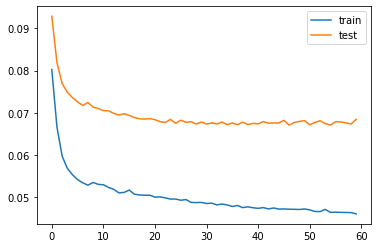

In [267]:
plot_history(basic_history)

In [325]:
def model_eval(model, X_test, y_test):
    """
    Evaluate (step-by-step) model predictions from X_test and return predictions and real values in comparable format.
    """
    # prepare data
    sales_x_cols = [col for col in X_test.columns if 'p' in col]
    print(sales_x_cols)
    sales_x_idxs = [X_test.columns.get_loc(col) for col in sales_x_cols]
    sales_y_cols = [col for col in y_test.columns if 's' in col]
    sales_y_idxs = [y_test.columns.get_loc(col) for col in sales_y_cols]
    n_samples = y_test.shape[0]
    y_pred = np.zeros(y_test.shape)
    # iterate
    x_next = X_test.iloc[0].values
    for i in range(0, n_samples):
        x_arr = np.array([x_next])
        x_arr = x_arr.reshape(x_arr.shape[0], 1, x_arr.shape[1])
        y_pred[i] = model.predict(x_arr)[0] # input for prediction must be 2d, output is immediately extracted from 2d to 1d
        try:
            x_next = X_test.iloc[i+1].values
            x_next[sales_x_idxs] = y_pred[i][sales_y_idxs]
        except IndexError:
            pass  # this happens on last iteration, and x_next does not matter anymore
    return y_pred, y_test.values

In [326]:
#y_valid.columns
X_valid.columns

Index(['s1_p_1', 's2_p_1', 's3_p_1', 's4_p_1', 's5_p_1', 's6_p_1', 's7_p_1',
       's8_p_1', 's9_p_1', 's10_p_1', 's11_p_1', 's12_p_1', 's13_p_1',
       's14_p_1', 's15_p_1', 's16_p_1', 's17_p_1', 's18_p_1', 's19_p_1',
       's20_p_1', 's21_p_1', 's22_p_1', 's23_p_1', 's24_p_1', 's25_p_1',
       's26_p_1', 's27_p_1', 's28_p_1', 's29_p_1', 's30_p_1', 's31_p_1',
       's32_p_1', 's33_p_1', 's34_p_1', 's35_p_1', 's36_p_1', 's37_p_1',
       's38_p_1', 's39_p_1', 's40_p_1', 's41_p_1', 's42_p_1', 's43_p_1',
       's44_p_1', 's45_p_1', 's46_p_1', 's47_p_1', 's48_p_1', 's49_p_1',
       's50_p_1', 's51_p_1', 's52_p_1', 's53_p_1', 's54_p_1', 'workday',
       'hols', 'w_1', 'w_2', 'w_3', 'w_4', 'w_5', 'w_6', 'm_2', 'm_3', 'm_4',
       'm_5', 'm_6', 'm_7', 'm_8', 'm_9', 'm_10', 'm_11', 'm_12'],
      dtype='object')

In [327]:
y_pred_basic, y_real = model_eval(basic_model, X_valid, y_valid)

['s1_p_1', 's2_p_1', 's3_p_1', 's4_p_1', 's5_p_1', 's6_p_1', 's7_p_1', 's8_p_1', 's9_p_1', 's10_p_1', 's11_p_1', 's12_p_1', 's13_p_1', 's14_p_1', 's15_p_1', 's16_p_1', 's17_p_1', 's18_p_1', 's19_p_1', 's20_p_1', 's21_p_1', 's22_p_1', 's23_p_1', 's24_p_1', 's25_p_1', 's26_p_1', 's27_p_1', 's28_p_1', 's29_p_1', 's30_p_1', 's31_p_1', 's32_p_1', 's33_p_1', 's34_p_1', 's35_p_1', 's36_p_1', 's37_p_1', 's38_p_1', 's39_p_1', 's40_p_1', 's41_p_1', 's42_p_1', 's43_p_1', 's44_p_1', 's45_p_1', 's46_p_1', 's47_p_1', 's48_p_1', 's49_p_1', 's50_p_1', 's51_p_1', 's52_p_1', 's53_p_1', 's54_p_1']


In [328]:
X_valid.columns

Index(['s1_p_1', 's2_p_1', 's3_p_1', 's4_p_1', 's5_p_1', 's6_p_1', 's7_p_1',
       's8_p_1', 's9_p_1', 's10_p_1', 's11_p_1', 's12_p_1', 's13_p_1',
       's14_p_1', 's15_p_1', 's16_p_1', 's17_p_1', 's18_p_1', 's19_p_1',
       's20_p_1', 's21_p_1', 's22_p_1', 's23_p_1', 's24_p_1', 's25_p_1',
       's26_p_1', 's27_p_1', 's28_p_1', 's29_p_1', 's30_p_1', 's31_p_1',
       's32_p_1', 's33_p_1', 's34_p_1', 's35_p_1', 's36_p_1', 's37_p_1',
       's38_p_1', 's39_p_1', 's40_p_1', 's41_p_1', 's42_p_1', 's43_p_1',
       's44_p_1', 's45_p_1', 's46_p_1', 's47_p_1', 's48_p_1', 's49_p_1',
       's50_p_1', 's51_p_1', 's52_p_1', 's53_p_1', 's54_p_1', 'workday',
       'hols', 'w_1', 'w_2', 'w_3', 'w_4', 'w_5', 'w_6', 'm_2', 'm_3', 'm_4',
       'm_5', 'm_6', 'm_7', 'm_8', 'm_9', 'm_10', 'm_11', 'm_12'],
      dtype='object')

In [329]:
template_df = pd.concat([X_valid, y_valid], axis=1)
template_df['is_test'] = np.repeat(True, template_df.shape[0])

In [330]:
def unscale(y_arr, scaler, template_df, series_names, toint=False):
    """
    Unscale array y_arr of model predictions, based on a scaler fitted 
    to template_df.
    """
    tmp = template_df.copy()
    tmp[y_cols] = pd.DataFrame(y_arr, index=tmp.index)
    tmp[series_names] = scaler.inverse_transform(tmp[series_names])
    if toint:
        return tmp[y_cols].astype(int)
    return tmp[y_cols]

In [340]:
basic_pred = unscale(y_pred_basic, scaler, template_df, series_names, toint=True)
basic_pred

s1  s2  s3  s4  s5  s6  s7  s8  s9  s10  ...  s45  s46  s47  s48  \
date                                                 ...                       
2017-04-22   3   2   9   4   0   2   0   6   0    0  ...    7   13   17   13   
2017-04-23   1   2  11   6   0   3   1   6   0    0  ...    6   12   16   14   
2017-04-24   2   1   6   2   0   2   1   4   0    0  ...    3    8   10    7   
2017-04-25   1   1   4   2   0   1   1   3   0    0  ...    2    6    8    4   
2017-04-26   2   0   5   2   1   1   2   4   0    0  ...    2    7    9    5   
...         ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ...   
2017-08-11   0   3   6   1   0   1   0   4   0    0  ...    1   10    7    4   
2017-08-12   1   4   6   1   1   2   1   5   0    0  ...    3   12   11    6   
2017-08-13   0   5  10   4   1   3   1   6   0    0  ...    3   12   12    9   
2017-08-14   1   3   6   1   1   2   1   5   0    0  ...    1    9    8    3   
2017-08-15   0   3   4   1   1   1   1   3   0    0  ...    1    7    6    2   

            s49  s50  s51  s52  s53  s54  
date                                      
2017-04-22    1    0    2    0    0    0  
2017-04-23    3    0    3    0    0    0  
2017-04-24    1    0    2    0    0    0  
2017-04-25    1    0    2    0    0    0  
2017-04-26    2    0    2    0    0    0  
...         ...  ...  ...  ...  ...  ...  
2017-08-11    2    0    2    0    0    0  
2017-08-12    1    0    2    0    0    0  
2017-08-13    3    0    3    0    0    0  
2017-08-14    1    0    2    0    0    0  
2017-08-15    1    0    3    0    0    0  

[116 rows x 54 columns]

In [341]:
real = unscale(y_real, scaler, template_df, series_names, toint=True)

In [342]:
real

s1  s2  s3  s4  s5  s6  s7  s8  s9  s10  ...  s45  s46  s47  s48  \
date                                                 ...                       
2017-04-22   5   5   9   5   1   4   4   5   0    0  ...   19   17   13   12   
2017-04-23   2   1  11   5   0   7   1   2   0    0  ...   13   20    9   22   
2017-04-24   5   2   3   8   0   1   2   4   0    0  ...    8    9    2    9   
2017-04-25   1   0   1   7   0   1   2   0   0    0  ...    2    9    4    6   
2017-04-26   4   4   1  12   0   6   3   5   0    0  ...    9   11   10    8   
...         ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ...   
2017-08-11   1   2  19   0   1   5   2   0   0    0  ...    6   21    8   10   
2017-08-12   0   1  17   0   2   2   0   0   0    0  ...    9   11   11   13   
2017-08-13   0   7   8   0   2   6   0   3   0    0  ...    9   25    9   13   
2017-08-14   1   3   7   0   1   4   0   1   0    0  ...    9   18   10    8   
2017-08-15   2   1  10   0   2   7   1   3   0    0  ...    1   23    2   15   

            s49  s50  s51  s52  s53  s54  
date                                      
2017-04-22    3    0    6    9    2    0  
2017-04-23   10    0   17   23    0    0  
2017-04-24    0    0    2    4    1    0  
2017-04-25    1    0   25    7    0    0  
2017-04-26    4    0    7    5    2    0  
...         ...  ...  ...  ...  ...  ...  
2017-08-11    2    0    5   10    0    0  
2017-08-12    4    0    3   13    0    0  
2017-08-13    3    0    6   19    0    0  
2017-08-14    3    0    4    5    0    0  
2017-08-15    3    0    5   11    0    0  

[116 rows x 54 columns]

In [343]:
np.sqrt(np.mean(np.nan_to_num(np.square(np.log(preds + 1) - np.log(real + 1)))))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


0.7811920396755764

In [344]:
pd.DataFrame(preds)

0         1          2         3         4         5         6   \
0    5.130422  2.987832  10.750245  5.859585  0.657283  2.805941  0.955983   
1    5.030119  5.044716  14.292349  6.220866 -0.236657  4.179366  1.648435   
2    7.709630  1.778653  11.131835  2.271656 -1.948961  1.534798 -2.532222   
3    3.158962  0.262365   4.410917  5.360294 -0.584570  1.710053  0.725074   
4    2.718068  2.836896   5.034953  2.187346 -0.198821  2.436044 -0.091525   
..        ...       ...        ...       ...       ...       ...       ...   
111  4.344070  5.784283   5.516365  3.865152  0.745883  0.983326 -1.080138   
112  4.432708  5.152067   9.013550  6.492528  0.510555  0.147557 -2.889930   
113  5.208145  5.250742  10.772030  8.675394  1.967593  1.259155 -1.712970   
114  5.372257  2.654936   7.088641  2.160727 -1.300443 -2.939064 -1.358408   
115  2.209674  4.502160   7.809031  4.441282  0.947219 -0.692690 -0.281763   

            7    8    9   ...         44         45         46         47  \
0     9.349070  0.0  0.0  ...   9.170762  12.801088  18.639556  14.151388   
1    11.394874  0.0  0.0  ...  12.053247  15.102837  22.404217  18.412715   
2    18.945698  0.0  0.0  ...  12.807761  12.949214  18.526449  19.051615   
3     2.830828  0.0  0.0  ...   5.189347   8.352492  16.798432  11.536083   
4    10.574818  0.0  0.0  ...   7.633159  10.683904  16.377969  10.095021   
..         ...  ...  ...  ...        ...        ...        ...        ...   
111   4.899875  0.0  0.0  ...   7.869307  18.325749  15.159873  10.605483   
112   9.693642  0.0  0.0  ...  11.191553  18.128670  13.483294  14.166282   
113   9.923941  0.0  0.0  ...  11.100837  17.510600  16.956305  20.074111   
114  13.504236  0.0  0.0  ...   7.194176  14.463137  16.437640  12.636636   
115   5.843771  0.0  0.0  ...   8.432717  14.158659  13.426692   9.429680   

           48        49        50        51        52   53  
0    3.008724 -0.147720  1.583179  0.993089  0.313007  0.0  
1    1.577227  0.384768  1.620025  2.291063  0.374717  0.0  
2   -5.747816  1.353216 -1.689541  5.490929 -2.825699  0.0  
3    2.114214  0.318494 -0.215088  1.187045  0.448318  0.0  
4   -2.037327 -0.558191  2.645877  1.715969 -0.652853  0.0  
..        ...       ...       ...       ...       ...  ...  
111 -0.470822 -0.754299  1.602489  1.100726 -0.269110  0.0  
112 -1.761800  0.145550  0.176346  1.965139 -0.361358  0.0  
113 -1.761187  0.156438  0.731230  2.695405 -0.269078  0.0  
114 -3.477849  0.387755 -2.171192  3.741356 -1.686383  0.0  
115 -1.036368 -0.299182  1.278124  1.182796 -0.205954  0.0  

[116 rows x 54 columns]

In [347]:
X_cols_stacked = [col for col in df_test.columns if 'p_' in col]
X_cols_caldata = [col for col in df_test.columns if 'w_' in col or 'm_' in col or 'workday' in col or 'hols' in col]
X_cols = X_cols_stacked + X_cols_caldata

X_test = df_test[X_cols]
X_test

s1_p_1  s2_p_1  s3_p_1  s4_p_1    s5_p_1    s6_p_1    s7_p_1  \
date                                                                         
2017-08-16  0.117647    0.05    0.25     0.0  0.222222  0.466667  0.038462   
2017-08-17  0.000000    0.00    0.00     0.0  0.000000  0.000000  0.000000   
2017-08-18  0.000000    0.00    0.00     0.0  0.000000  0.000000  0.000000   
2017-08-19  0.000000    0.00    0.00     0.0  0.000000  0.000000  0.000000   
2017-08-20  0.000000    0.00    0.00     0.0  0.000000  0.000000  0.000000   
2017-08-21  0.000000    0.00    0.00     0.0  0.000000  0.000000  0.000000   
2017-08-22  0.000000    0.00    0.00     0.0  0.000000  0.000000  0.000000   
2017-08-23  0.000000    0.00    0.00     0.0  0.000000  0.000000  0.000000   
2017-08-24  0.000000    0.00    0.00     0.0  0.000000  0.000000  0.000000   
2017-08-25  0.000000    0.00    0.00     0.0  0.000000  0.000000  0.000000   
2017-08-26  0.000000    0.00    0.00     0.0  0.000000  0.000000  0.000000   
2017-08-27  0.000000    0.00    0.00     0.0  0.000000  0.000000  0.000000   
2017-08-28  0.000000    0.00    0.00     0.0  0.000000  0.000000  0.000000   
2017-08-29  0.000000    0.00    0.00     0.0  0.000000  0.000000  0.000000   
2017-08-30  0.000000    0.00    0.00     0.0  0.000000  0.000000  0.000000   
2017-08-31  0.000000    0.00    0.00     0.0  0.000000  0.000000  0.000000   

              s8_p_1  s9_p_1  s10_p_1  ...  m_3  m_4  m_5  m_6  m_7  m_8  m_9  \
date                                   ...                                      
2017-08-16  0.081081     0.0      0.0  ...    0    0    0    0    0    1    0   
2017-08-17  0.000000     0.0      0.0  ...    0    0    0    0    0    1    0   
2017-08-18  0.000000     0.0      0.0  ...    0    0    0    0    0    1    0   
2017-08-19  0.000000     0.0      0.0  ...    0    0    0    0    0    1    0   
2017-08-20  0.000000     0.0      0.0  ...    0    0    0    0    0    1    0   
2017-08-21  0.000000     0.0      0.0  ...    0    0    0    0    0    1    0   
2017-08-22  0.000000     0.0      0.0  ...    0    0    0    0    0    1    0   
2017-08-23  0.000000     0.0      0.0  ...    0    0    0    0    0    1    0   
2017-08-24  0.000000     0.0      0.0  ...    0    0    0    0    0    1    0   
2017-08-25  0.000000     0.0      0.0  ...    0    0    0    0    0    1    0   
2017-08-26  0.000000     0.0      0.0  ...    0    0    0    0    0    1    0   
2017-08-27  0.000000     0.0      0.0  ...    0    0    0    0    0    1    0   
2017-08-28  0.000000     0.0      0.0  ...    0    0    0    0    0    1    0   
2017-08-29  0.000000     0.0      0.0  ...    0    0    0    0    0    1    0   
2017-08-30  0.000000     0.0      0.0  ...    0    0    0    0    0    1    0   
2017-08-31  0.000000     0.0      0.0  ...    0    0    0    0    0    1    0   

            m_10  m_11  m_12  
date                          
2017-08-16     0     0     0  
2017-08-17     0     0     0  
2017-08-18     0     0     0  
2017-08-19     0     0     0  
2017-08-20     0     0     0  
2017-08-21     0     0     0  
2017-08-22     0     0     0  
2017-08-23     0     0     0  
2017-08-24     0     0     0  
2017-08-25     0     0     0  
2017-08-26     0     0     0  
2017-08-27     0     0     0  
2017-08-28     0     0     0  
2017-08-29     0     0     0  
2017-08-30     0     0     0  
2017-08-31     0     0     0  

[16 rows x 73 columns]

In [355]:
X_colset = set(X_cols)
print(X_colset)
y_cols = [col for col in df0.columns if col not in X_colset]
print(y_cols)
y_test = df_test[y_cols]
y_test.columns
y_test

{'s2_p_1', 's7_p_1', 's15_p_1', 's27_p_1', 's37_p_1', 's48_p_1', 's20_p_1', 'm_5', 's26_p_1', 's4_p_1', 's5_p_1', 's44_p_1', 's23_p_1', 's51_p_1', 's3_p_1', 's28_p_1', 's50_p_1', 'm_9', 's8_p_1', 's19_p_1', 's34_p_1', 's32_p_1', 's43_p_1', 'w_1', 'w_5', 'm_6', 'm_12', 's24_p_1', 'm_8', 's31_p_1', 's16_p_1', 's13_p_1', 's10_p_1', 'm_3', 'm_10', 's1_p_1', 's29_p_1', 's6_p_1', 's36_p_1', 'm_4', 's22_p_1', 'hols', 's33_p_1', 's38_p_1', 's11_p_1', 'm_7', 's25_p_1', 'w_4', 'w_6', 's30_p_1', 's47_p_1', 's14_p_1', 's12_p_1', 'w_2', 's41_p_1', 's46_p_1', 's35_p_1', 's17_p_1', 's49_p_1', 's40_p_1', 'm_2', 's18_p_1', 's45_p_1', 's54_p_1', 'm_11', 'workday', 's21_p_1', 's53_p_1', 'w_3', 's39_p_1', 's9_p_1', 's42_p_1', 's52_p_1'}
['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27', 's28', 's29', 's30', 's31', 's32', 's33', 's34', 's35', 's36', 's37', 's38', 's39', 's40', '

s1   s2   s3   s4   s5   s6   s7   s8   s9  s10  ...  s45  s46  \
date                                                          ...             
2017-08-16  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-17  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-18  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-19  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-21  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-22  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-23  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-24  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-25  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-26  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-27  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-28  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-29  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-30  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-31  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

            s47  s48  s49  s50  s51  s52  s53  s54  
date                                                
2017-08-16  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-17  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-18  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-19  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-21  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-22  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-23  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-24  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-25  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-26  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-27  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-28  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-29  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-30  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-31  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[16 rows x 54 columns]

In [348]:
X_test_vals = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [349]:
X_test_vals

array([[[0.11764706, 0.05      , 0.25      , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       ...,

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]])

In [357]:
sales_x_cols = [col for col in X_test.columns if 'p' in col]
print(sales_x_cols)
sales_x_idxs = [X_test.columns.get_loc(col) for col in sales_x_cols]
print(sales_x_idxs)

['s1_p_1', 's2_p_1', 's3_p_1', 's4_p_1', 's5_p_1', 's6_p_1', 's7_p_1', 's8_p_1', 's9_p_1', 's10_p_1', 's11_p_1', 's12_p_1', 's13_p_1', 's14_p_1', 's15_p_1', 's16_p_1', 's17_p_1', 's18_p_1', 's19_p_1', 's20_p_1', 's21_p_1', 's22_p_1', 's23_p_1', 's24_p_1', 's25_p_1', 's26_p_1', 's27_p_1', 's28_p_1', 's29_p_1', 's30_p_1', 's31_p_1', 's32_p_1', 's33_p_1', 's34_p_1', 's35_p_1', 's36_p_1', 's37_p_1', 's38_p_1', 's39_p_1', 's40_p_1', 's41_p_1', 's42_p_1', 's43_p_1', 's44_p_1', 's45_p_1', 's46_p_1', 's47_p_1', 's48_p_1', 's49_p_1', 's50_p_1', 's51_p_1', 's52_p_1', 's53_p_1', 's54_p_1']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]


In [358]:
sales_y_cols = [col for col in y_test.columns if 's' in col]
sales_y_idxs = [y_test.columns.get_loc(col) for col in sales_y_cols]
n_samples = y_test.shape[0]
y_pred = np.zeros(y_test.shape)
# iterate
x_next = X_test.iloc[0].values

for i in range(0, n_samples):
    x_arr = np.array([x_next])
    x_arr = x_arr.reshape(x_arr.shape[0], 1, x_arr.shape[1])
    y_pred[i] = model.predict(x_arr)[0] # input for prediction must be 2d, output is immediately extracted from 2d to 1d
    try:
        x_next = X_test.iloc[i+1].values
        x_next[sales_x_idxs] = y_pred[i][sales_y_idxs]
    except IndexError:
        pass  # this happens on last iteration, and x_next does not matter anymore
    

In [362]:
pd.DataFrame(y_pred)

0         1         2         3         4         5         6   \
0   0.541823  0.551953  0.684139  0.627169  0.580397  0.617853  0.703926   
1   0.605490  0.616467  0.766384  0.705075  0.659724  0.698527  0.778858   
2   0.752659  0.760532  0.880692  0.830716  0.783909  0.831268  0.883625   
3   0.827992  0.829180  0.926684  0.887032  0.845580  0.890432  0.927076   
4   0.729218  0.733190  0.873187  0.822051  0.777853  0.817155  0.876193   
5   0.765927  0.770530  0.891552  0.843434  0.798501  0.843590  0.894040   
6   0.808150  0.809809  0.916065  0.874144  0.832597  0.874856  0.916369   
7   0.858759  0.861110  0.947421  0.914177  0.876766  0.914962  0.946226   
8   0.756376  0.762759  0.886616  0.837030  0.791890  0.835897  0.888310   
9   0.805829  0.812232  0.916310  0.873553  0.830299  0.875038  0.916584   
10  0.841594  0.842596  0.934757  0.897452  0.857449  0.900903  0.934643   
11  0.734174  0.738009  0.876551  0.826012  0.781883  0.821340  0.879304   
12  0.767663  0.772218  0.892701  0.844812  0.799953  0.845013  0.895096   
13  0.808649  0.810296  0.916373  0.874530  0.833018  0.875252  0.916658   
14  0.858863  0.861210  0.947475  0.914251  0.876853  0.915038  0.946278   
15  0.756410  0.762791  0.886638  0.837057  0.791917  0.835925  0.888331   

          7         8         9   ...        44        45        46        47  \
0   0.629801 -0.016338 -0.005430  ...  0.576496  0.636588  0.704820  0.690575   
1   0.700638 -0.015217 -0.006401  ...  0.647453  0.704485  0.779214  0.767448   
2   0.836449 -0.019345 -0.010220  ...  0.792534  0.840394  0.883619  0.878595   
3   0.896111 -0.020861 -0.011555  ...  0.859426  0.899539  0.926947  0.925697   
4   0.816986 -0.020053 -0.009265  ...  0.769494  0.822574  0.875566  0.870228   
5   0.848123 -0.019459 -0.010245  ...  0.803587  0.852360  0.893546  0.889792   
6   0.880232 -0.020274 -0.010981  ...  0.842726  0.884870  0.916975  0.914955   
7   0.921432 -0.023600 -0.013372  ...  0.889450  0.924830  0.946037  0.944966   
8   0.841300 -0.018197 -0.009451  ...  0.796914  0.845039  0.888917  0.884787   
9   0.880887 -0.020742 -0.011660  ...  0.843010  0.884480  0.916766  0.913787   
10  0.906485 -0.021312 -0.012012  ...  0.872056  0.909823  0.934564  0.933632   
11  0.821248 -0.020167 -0.009367  ...  0.774270  0.826835  0.878693  0.873578   
12  0.849570 -0.019500 -0.010286  ...  0.805248  0.853803  0.894615  0.890928   
13  0.880627 -0.020287 -0.010995  ...  0.843190  0.885260  0.917263  0.915259   
14  0.921504 -0.023604 -0.013375  ...  0.889541  0.924901  0.946089  0.945020   
15  0.841327 -0.018198 -0.009452  ...  0.796946  0.845067  0.888937  0.884809   

          48        49        50        51        52        53  
0   0.652439  0.019551  0.637320  0.002041  0.009509  0.012573  
1   0.739645  0.021617  0.714527  0.000859  0.011181  0.014600  
2   0.858035  0.024946  0.845850  0.002868  0.014514  0.018696  
3   0.909851  0.027505  0.901520  0.005471  0.018503  0.021154  
4   0.848887  0.029301  0.827328  0.003908  0.021107  0.019043  
5   0.869855  0.027044  0.856092  0.003468  0.016944  0.019292  
6   0.896533  0.028723  0.887892  0.004134  0.019667  0.021055  
7   0.932401  0.029892  0.925512  0.005317  0.020244  0.023911  
8   0.865465  0.025644  0.850459  0.002438  0.015378  0.019238  
9   0.897262  0.026611  0.888262  0.003565  0.016363  0.020819  
10  0.918978  0.028048  0.911548  0.005723  0.019202  0.021810  
11  0.852552  0.029422  0.831468  0.003988  0.021258  0.019192  
12  0.871116  0.027092  0.857491  0.003491  0.017009  0.019354  
13  0.896880  0.028740  0.888270  0.004142  0.019688  0.021075  
14  0.932464  0.029896  0.925582  0.005320  0.020250  0.023917  
15  0.865489  0.025645  0.850485  0.002439  0.015379  0.019239  

[16 rows x 54 columns]